# LSTM Time Series Prediction

In this notebook a LSTM is applied to predict the number of bike rentals in the next hour. A similar dataset has already been applied and described in the notebook [05Optimisation](05Optimisation.ipynb). However, now we access a .csv-file, which contains the bike-rental data of 2 years not in a daily, but in a hourly time resolution. 

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

#%matplotlib inline
#%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [30]:
import warnings
warnings.filterwarnings("ignore")

## Dataaccess and - Description

In [31]:
#bikefile="./Data/bikeday.csv"
bikefile="./Data/bikehour.csv"
bikedf=pd.read_csv(bikefile,index_col=0)
bikedf.head(10)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8


**Feature Description:**

- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not 
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)

**Target:**

- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In our regression - experiments only *cnt* is applied as target value. The distinction into *casual* and *registered* is neglected. 

### Modification of Dataformat
The pandas-dataframe is modified such, that a unique date-time-stamp, which speicifies the date and the hour, is created and applied as the dataframe's index. The advantage of such a date-time-index is that it enables the application of the [pandas dataframe resample method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) (see below).

In [32]:
def createTimeStamp(dayIn,hourIn):
    hour=pd.Timedelta(str(hourIn)+" hour")
    day=pd.to_datetime(dayIn)
    return day+hour

In [33]:
bikedf["timestamp"]=list(map(createTimeStamp,bikedf["dteday"],bikedf["hr"]))

In [34]:
bikedf.index=bikedf.timestamp

In [35]:
bikedf=bikedf.drop('timestamp',axis=1)

## Data Understanding by Visualization

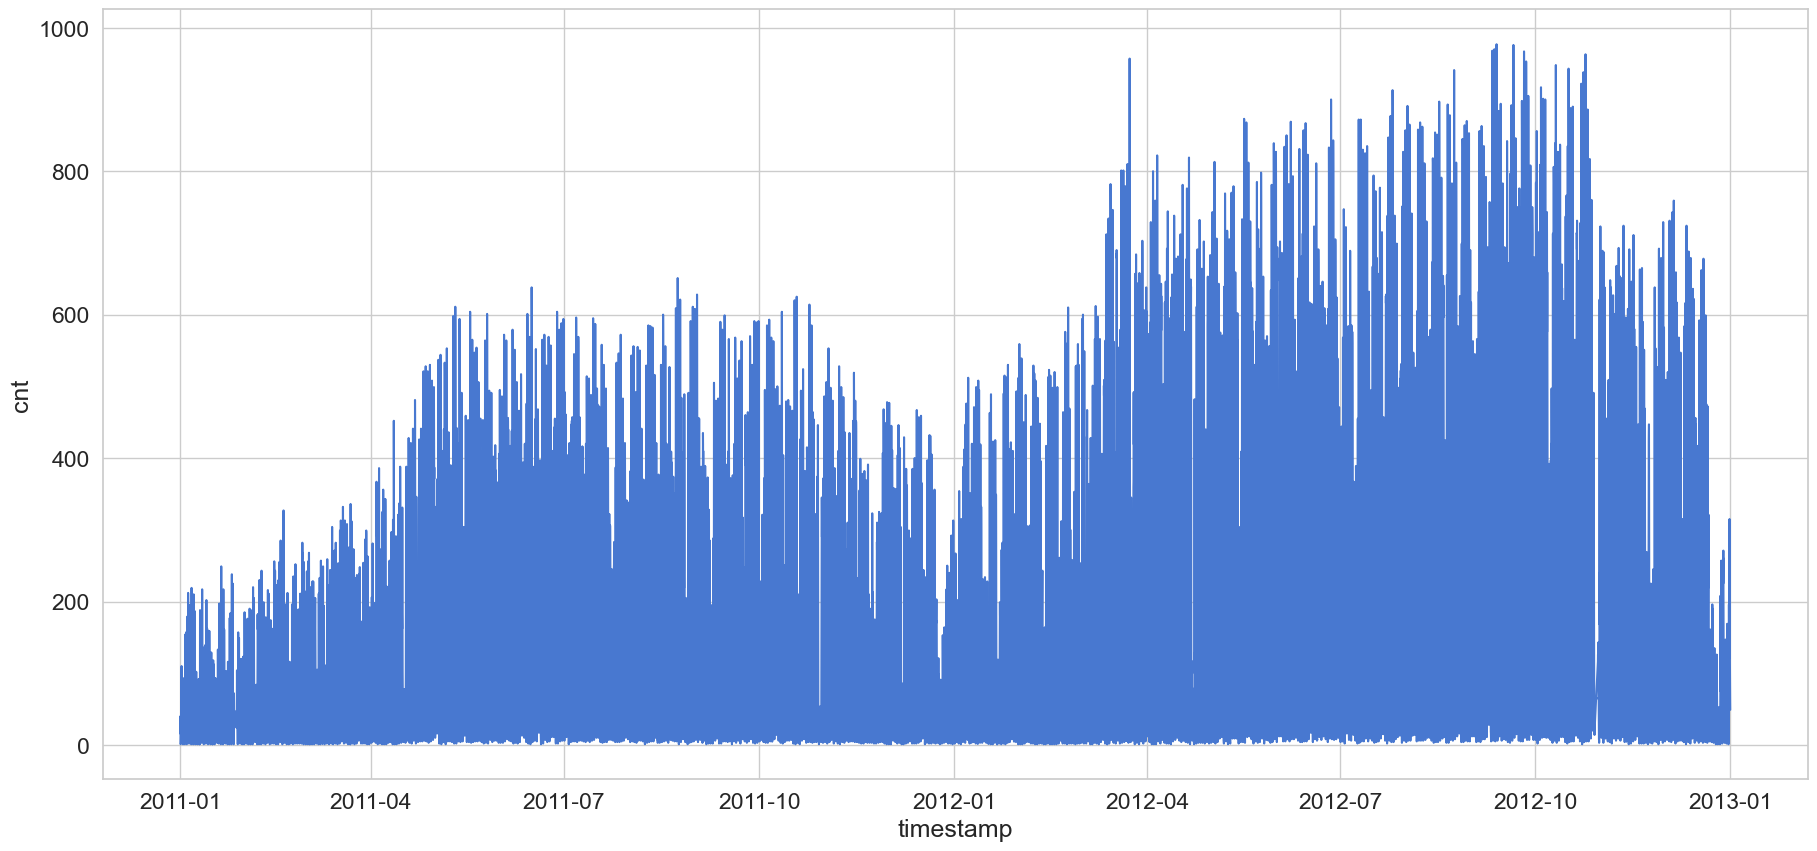

In [36]:
sns.lineplot(x=bikedf.index, y="cnt", data=bikedf);

In the previous plot bike-rentals are plotted in a hourly-time resolution. We can change the time-resolution from hour to month and accumulate the corresponding values by applying the 
[pandas dataframe resample method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html).

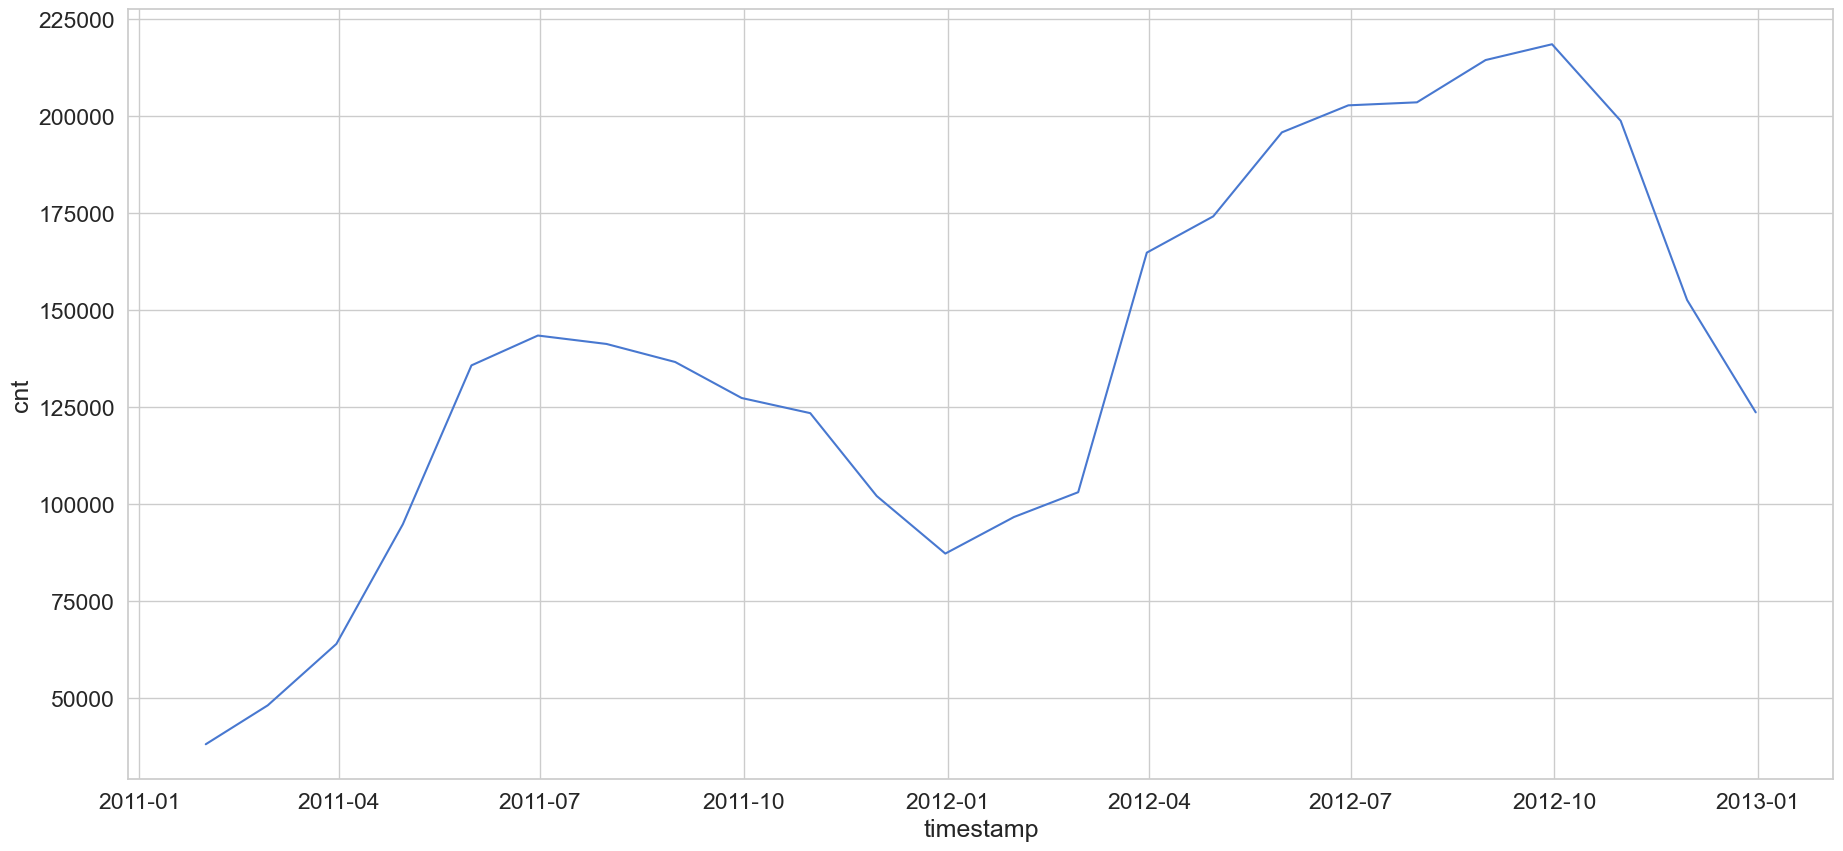

In [37]:
df_by_month = bikedf.resample('M').sum()
sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

The following grid of plots shows, how bike rentals vary over daytime (24 hours):

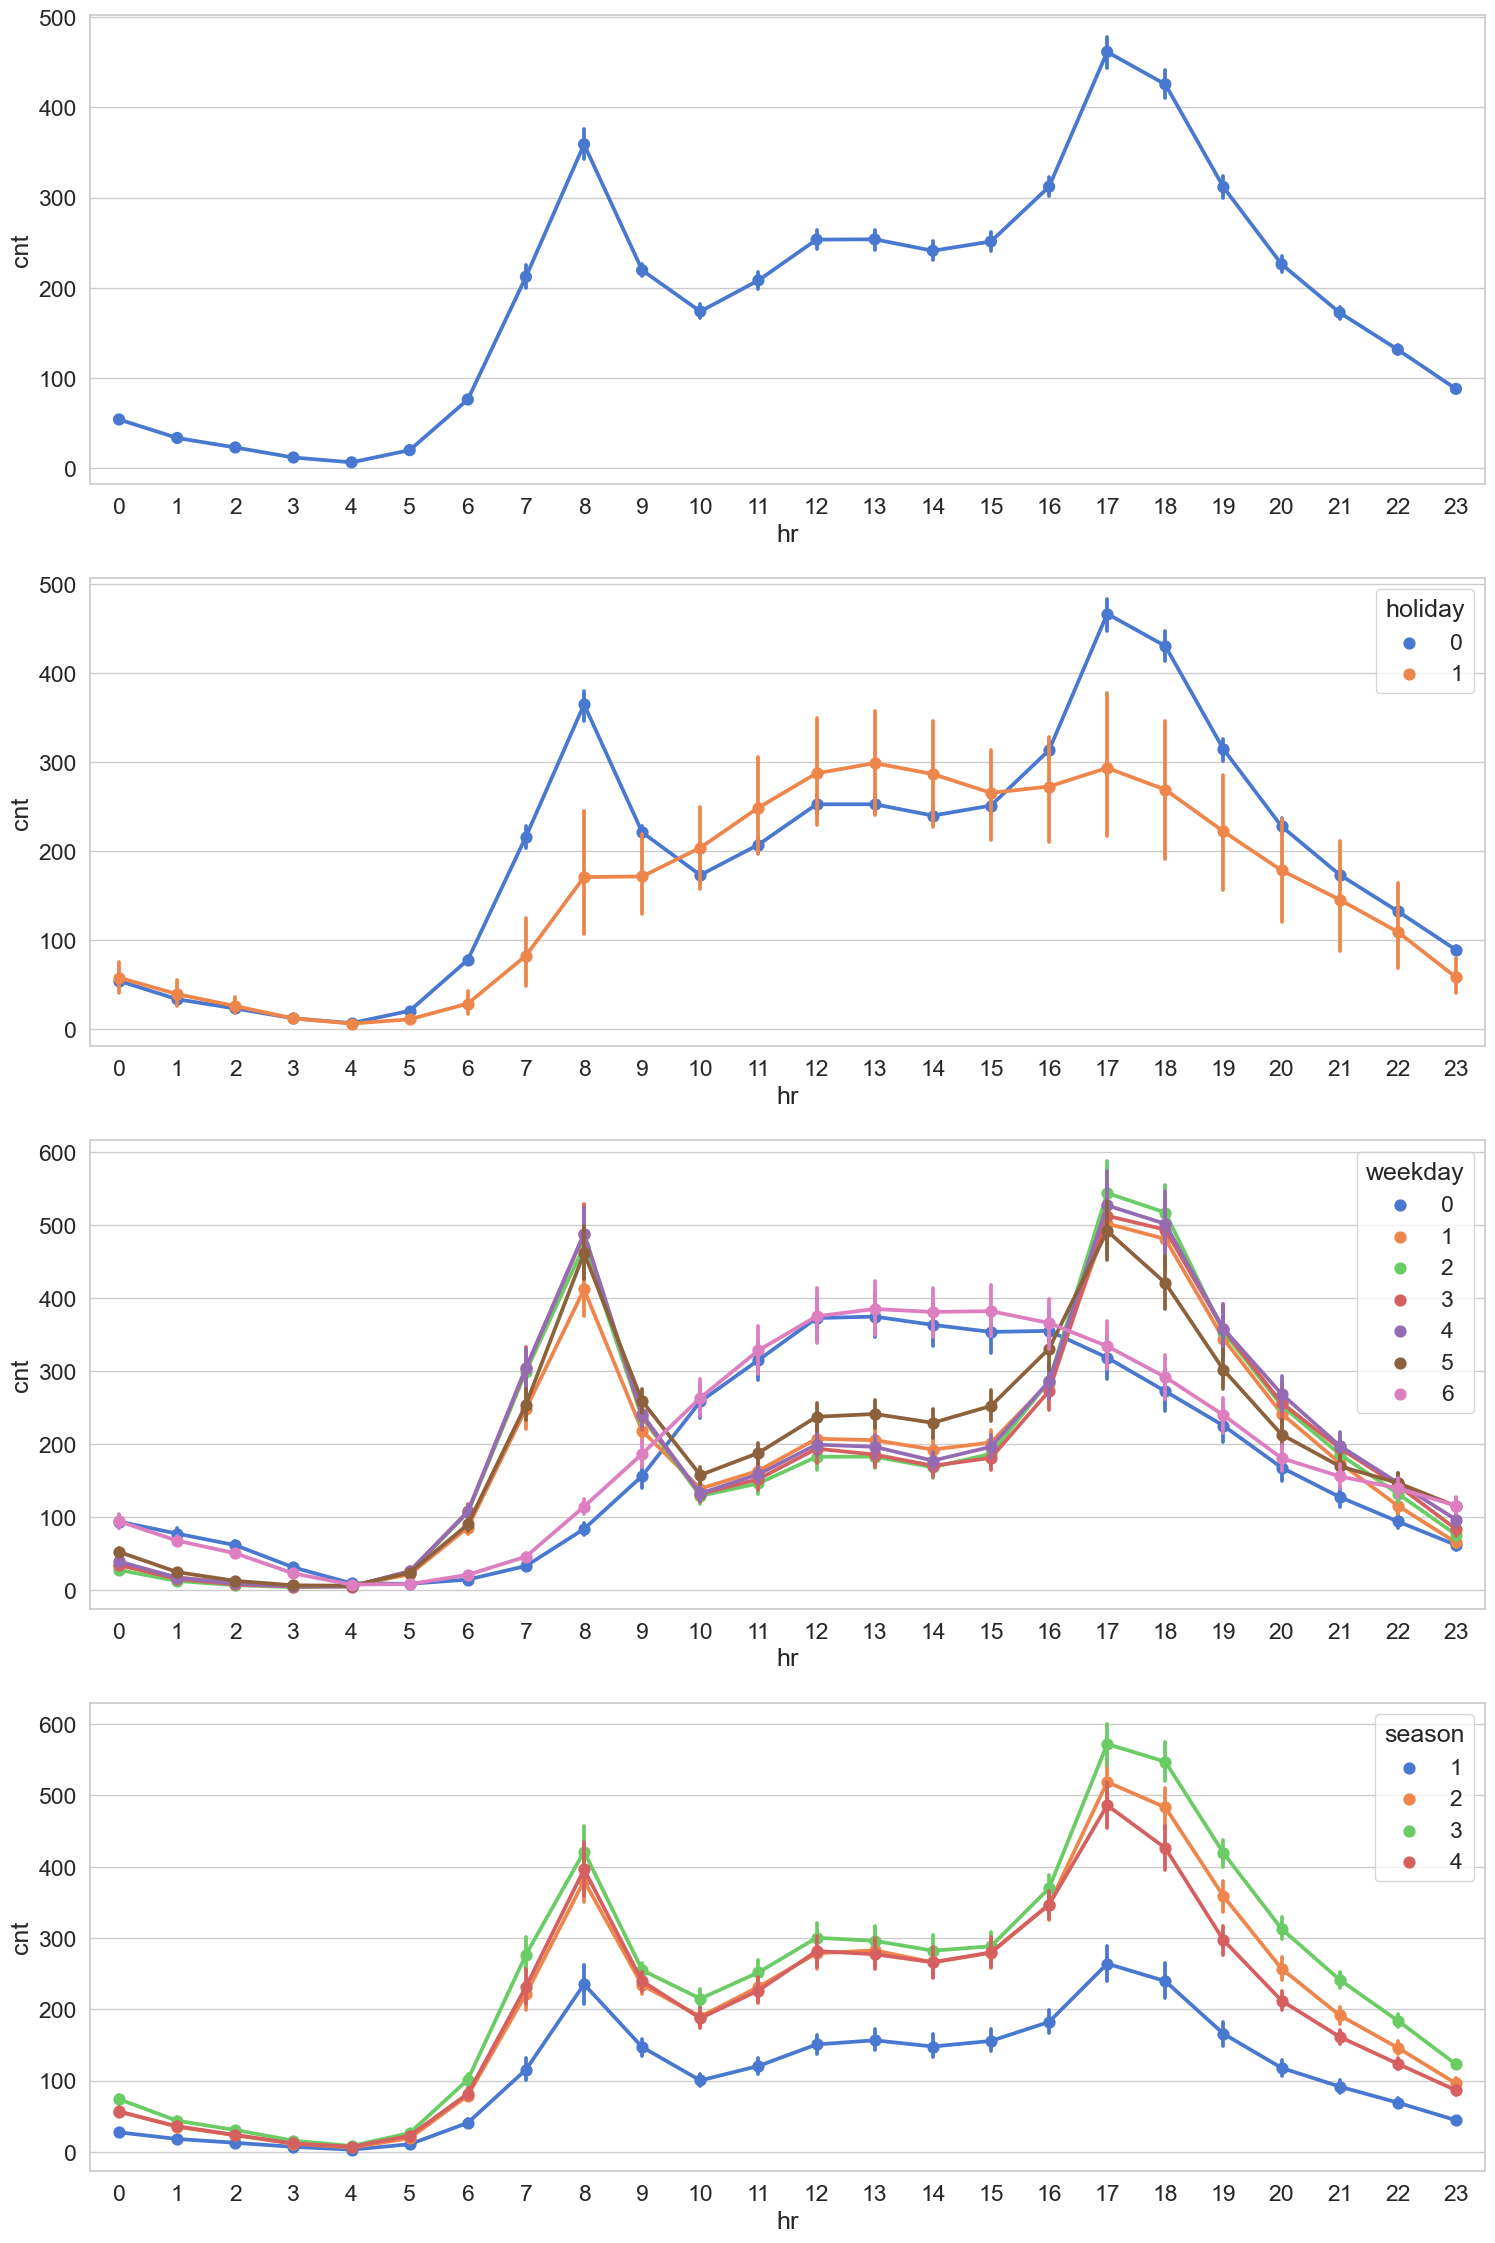

In [38]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=bikedf, x='hr', y='cnt', ax=ax1)
sns.pointplot(data=bikedf, x='hr', y='cnt', hue='holiday', ax=ax2)
sns.pointplot(data=bikedf, x='hr', y='cnt', hue='weekday', ax=ax3)
sns.pointplot(data=bikedf, x='hr', y='cnt', hue='season', ax=ax4);

The following 2 plots show, how bike rentals vary over the 7 days of week:

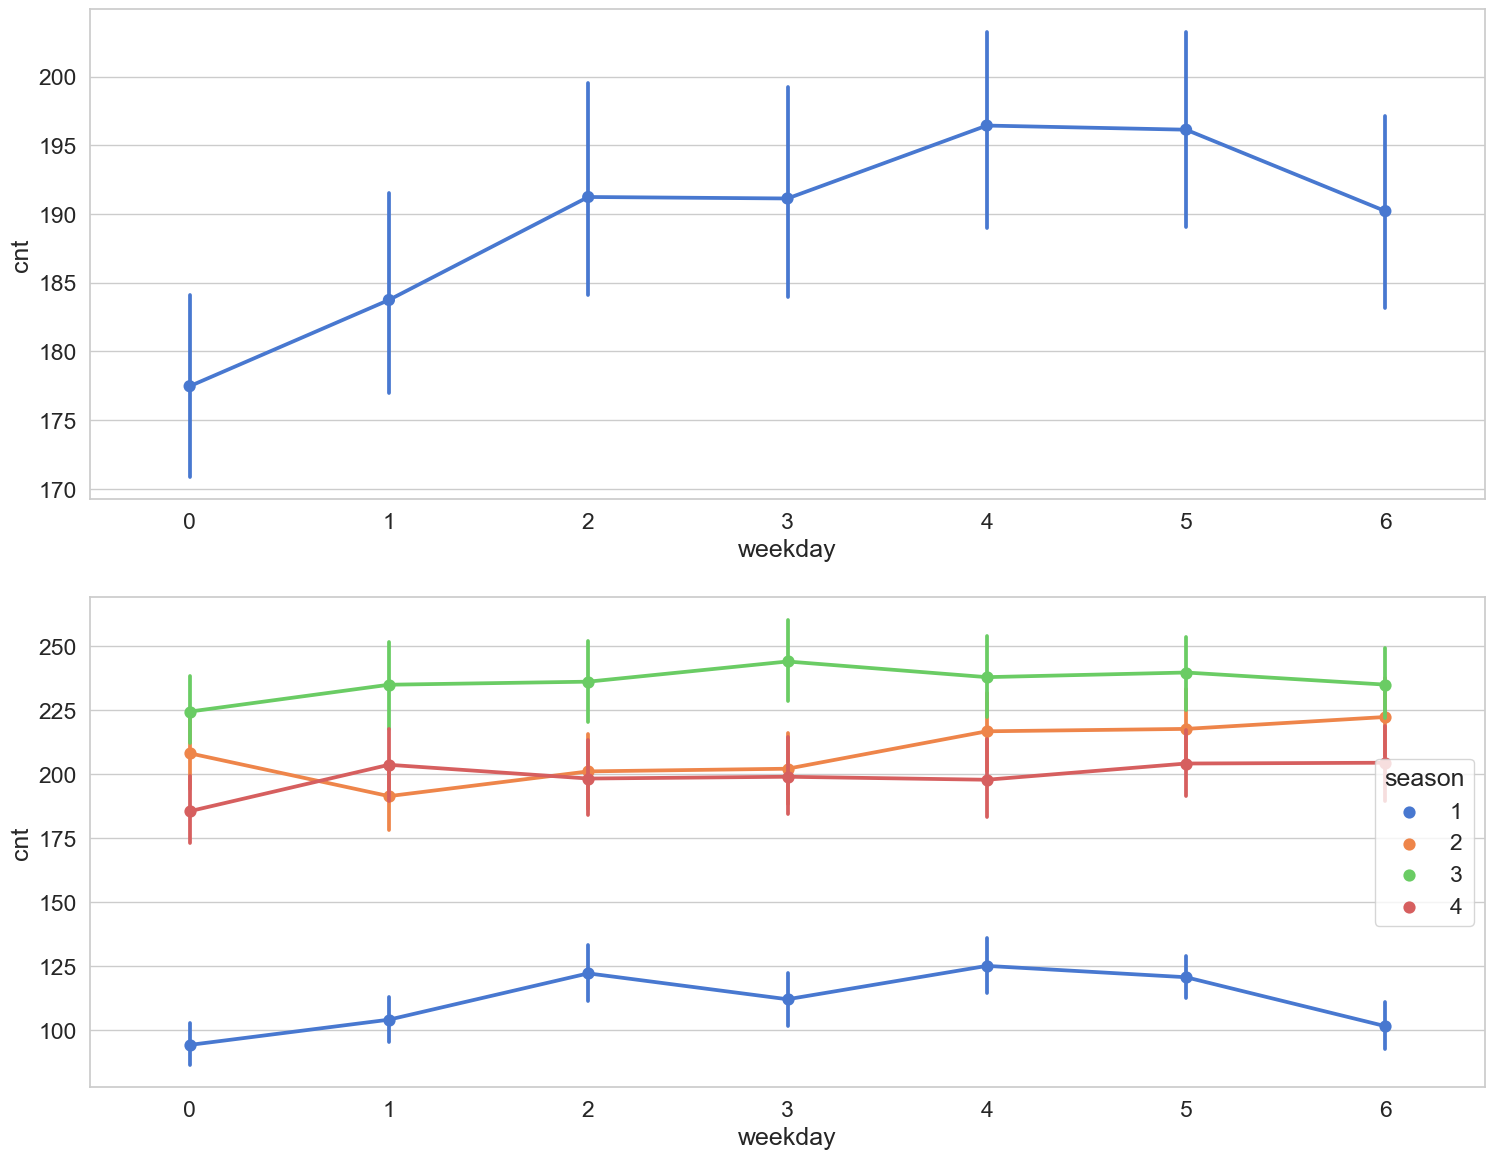

In [39]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=bikedf, x='weekday', y='cnt', ax=ax1)
sns.pointplot(data=bikedf, x='weekday', y='cnt', hue='season', ax=ax2);

The following 2 plots indicate the difference between registered and casual users. Casual users have a strong demand at the weekend, whereas registered user are more active during the week's workingdays. 

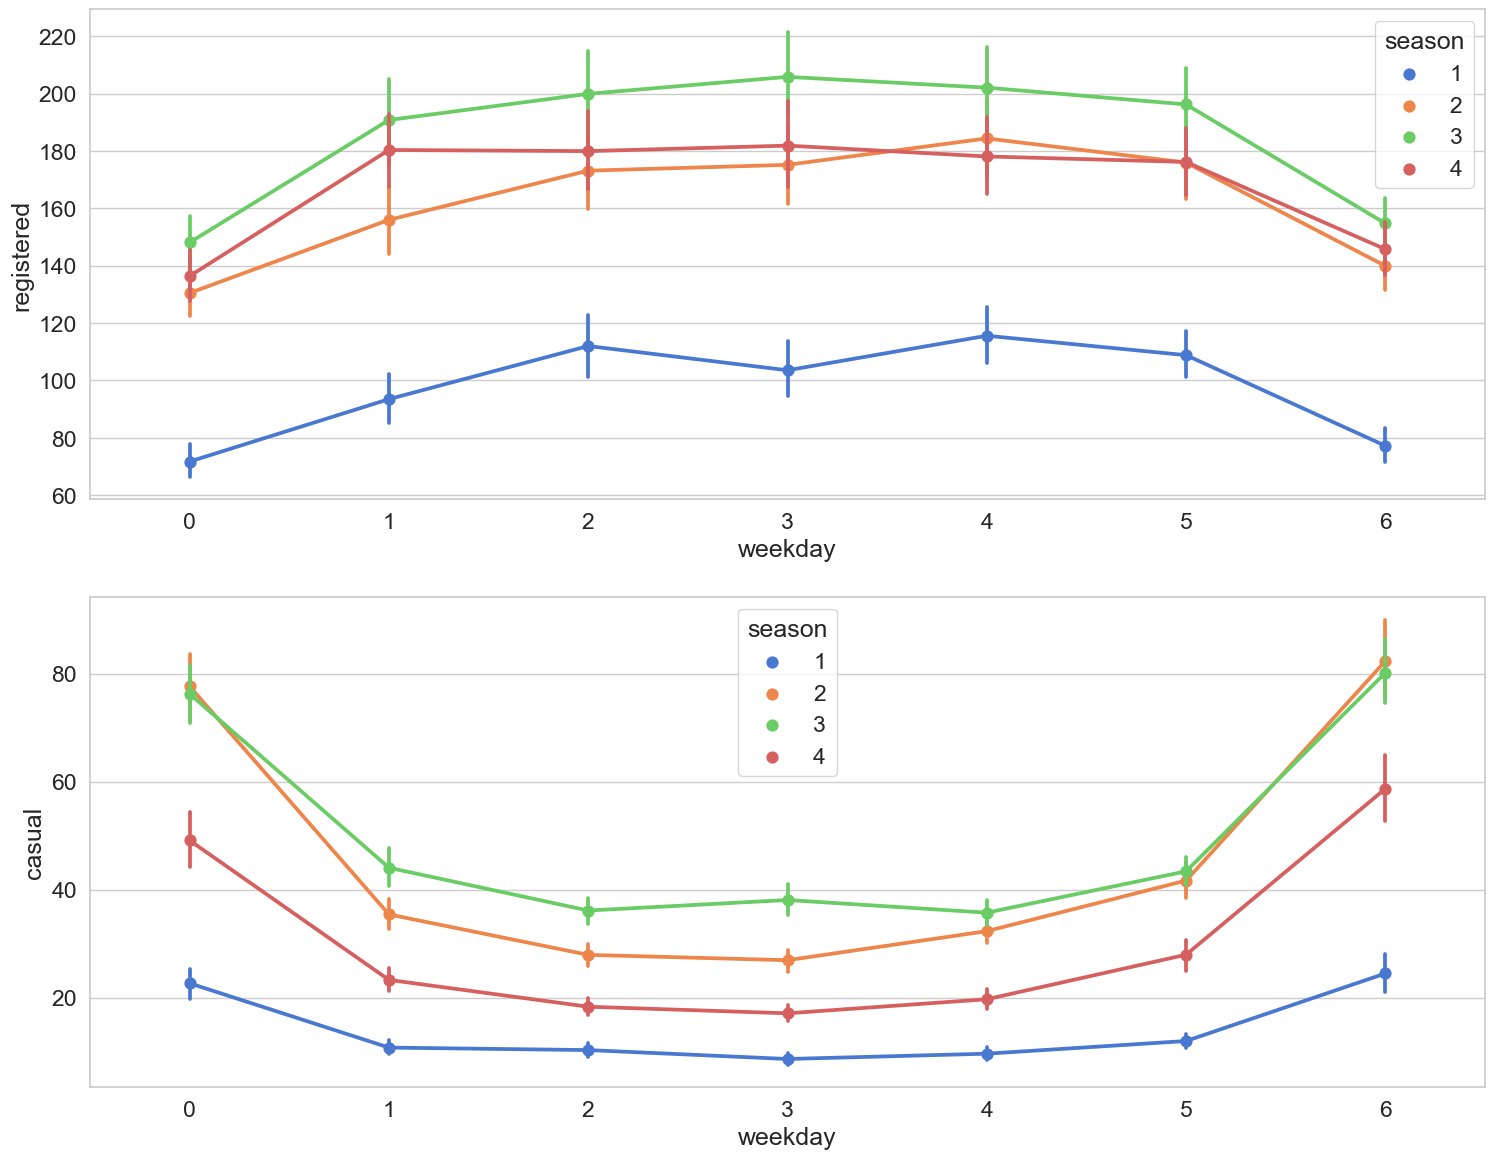

In [40]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=bikedf, x='weekday', y='registered', hue='season', ax=ax1)
sns.pointplot(data=bikedf, x='weekday', y='casual', hue='season', ax=ax2);

## Preprocessing and Configuration of Training- and Testdata
In the following experiments the columns `dteday` can be droped. Moreover, since we like to predict only the total number of bike-rental (column `cnt`), the columns `registered` and `casual` can also be dropped. 

The values of the remaining feature-columns are already in similar ranges, such that no further normalisation/standardisation is necessary.

In [41]:
bikedf=bikedf.drop(['dteday','registered','casual'],axis=1)

In [42]:
bikedf.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
timestamp,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
2011-01-01 03:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
2011-01-01 04:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


The task of this notebook is to predict from the `time_steps` previous samples (rows in the dataframe), the cnt-value of the next sample.   

The first 90% of available timestamps shall be applied for training, the remaining 10% for test. This split is not very smart, since the statistic within the test-period is different from the statistic of the training-period, as can be seen in the visualisation above. However, for the simple experiments of this notebook, we do not implement a better train-test-splitting.  

In [43]:
train_size = int(len(bikedf) * 0.9)
test_size = len(bikedf) - train_size
train, test = bikedf.iloc[0:train_size], bikedf.iloc[train_size:len(bikedf)]
print(len(train), len(test))

15641 1738


In [44]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [45]:
time_steps = 25

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15616, 25, 13) (15616,)
(1713, 25, 13) (1713,)


## Define Architecture and Training of bidirectional LSTM

In [46]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mae', optimizer='adam')

In [47]:
history = model.fit(
    X_train, y_train, 
    epochs=40, 
    batch_size=32,
    validation_data = (X_test,y_test),
    verbose=False,
    shuffle=False
)

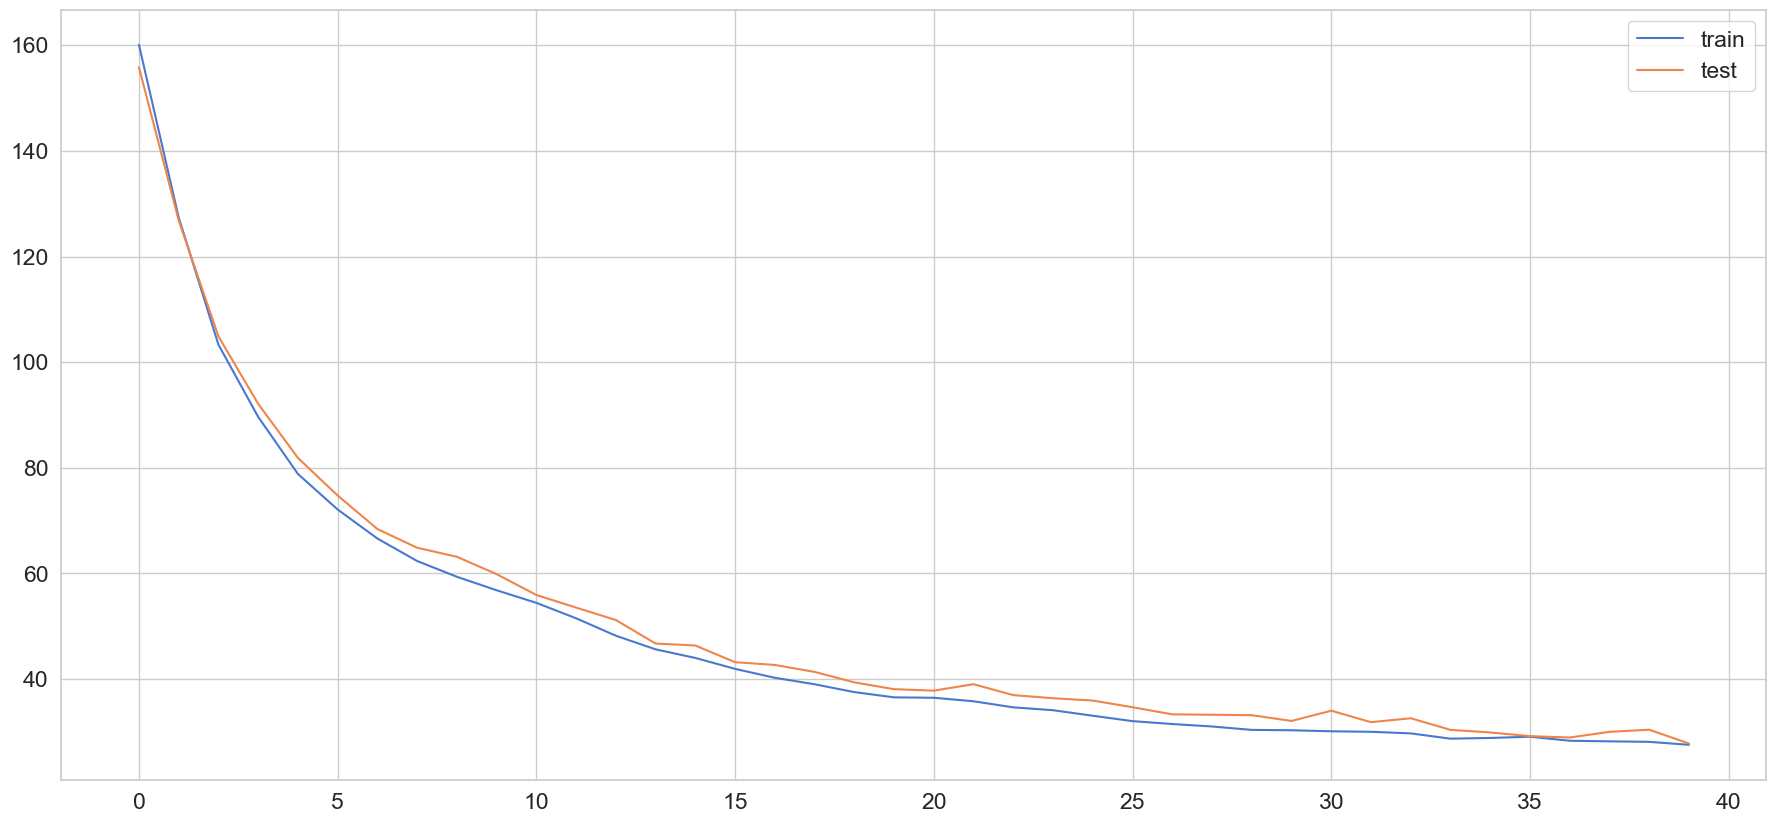

In [48]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## Evaluation of learned LSTM model

In [49]:
y_pred = model.predict(X_test)

54/54 [==============================] - 1s 5ms/step


In [50]:
from utilsJM import determineRegressionMetrics

In [51]:
determineRegressionMetrics(y_test,y_pred)


Mean absolute error = 27.82
Mean squared error = 2018.16
Median absolute error = 15.13
R2 score = 0.94
Explained variance score = 0.94


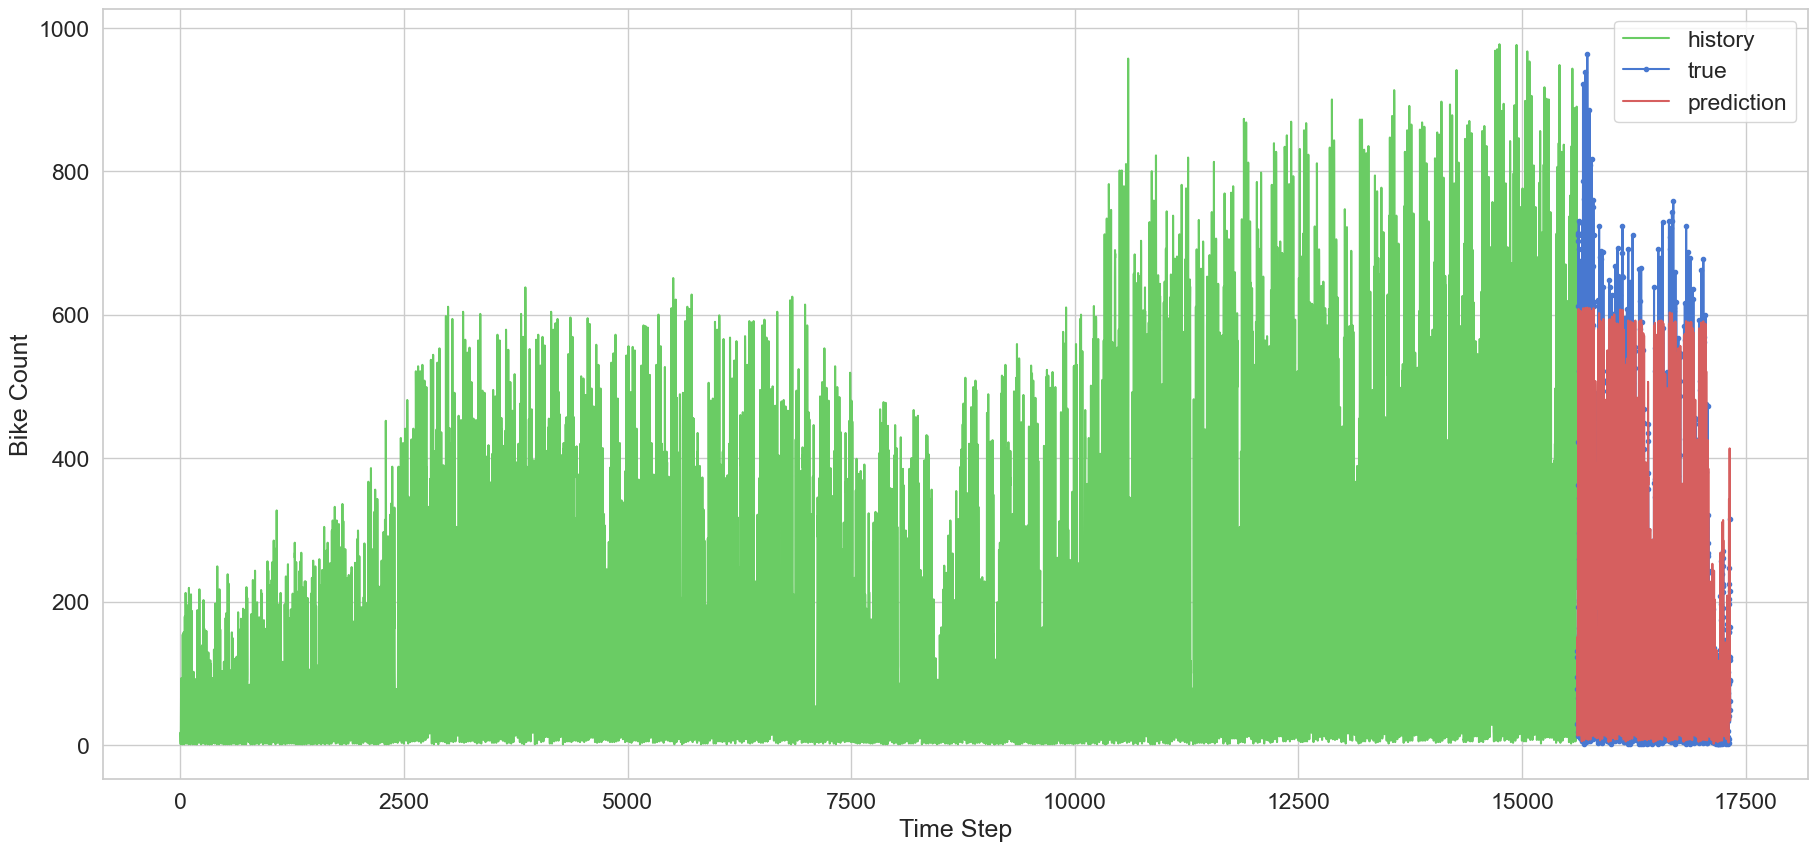

In [52]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

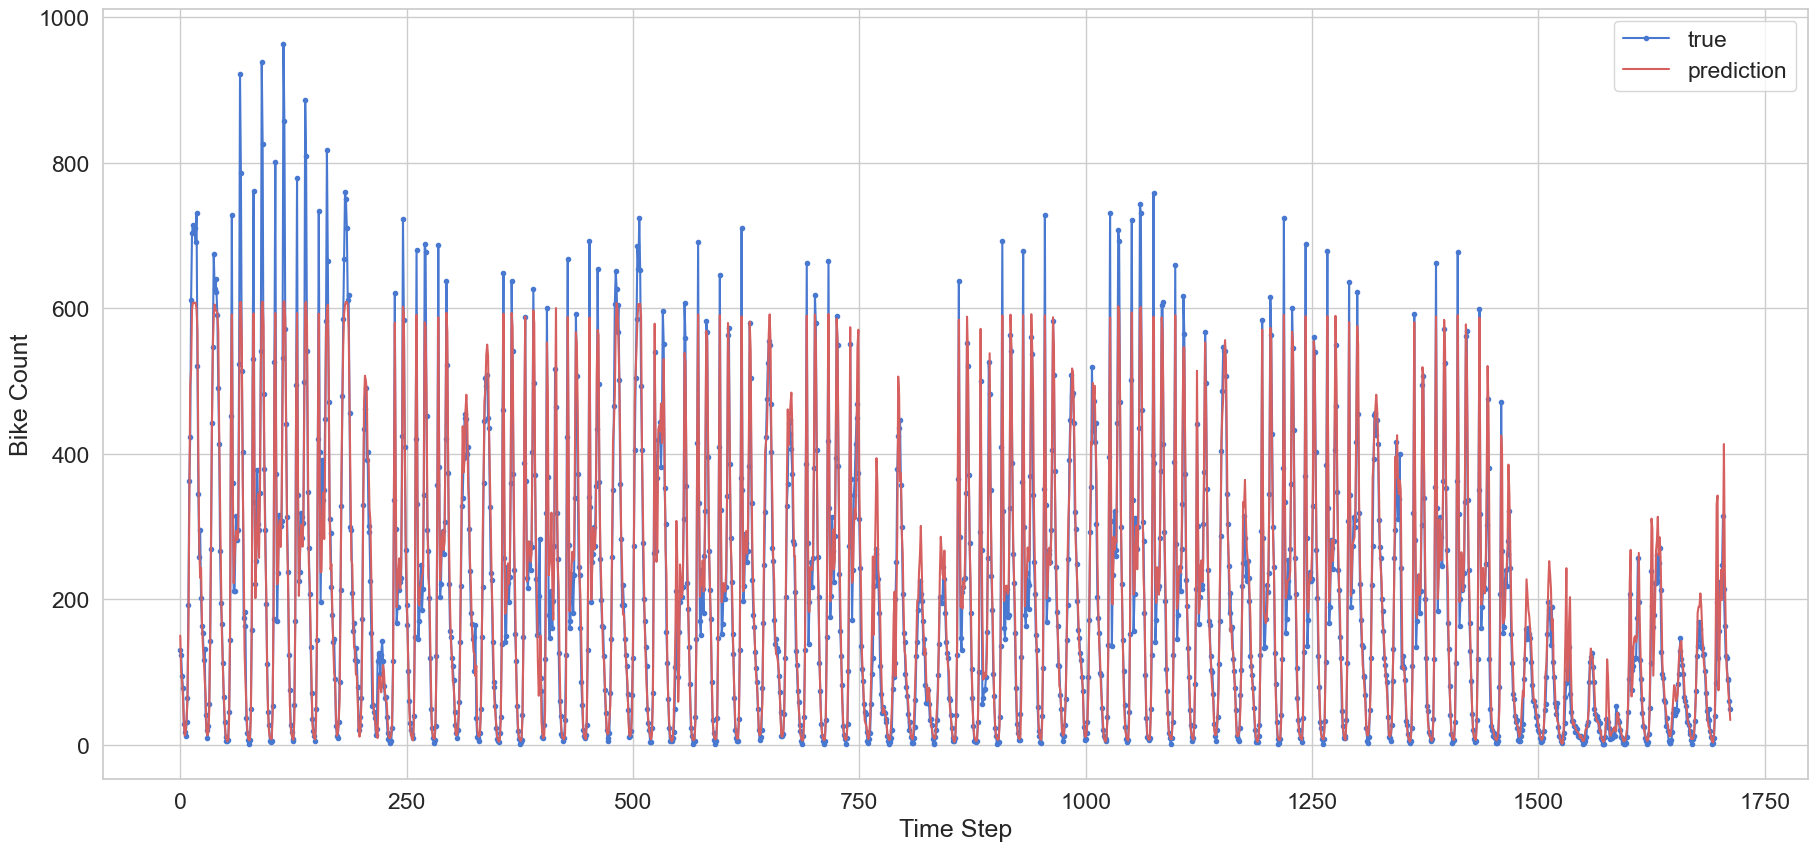

In [53]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

### Comparison with simple Baseline Model

For comparison a simple baseline-model is evaluated. The baseline just predicts the bike rentals of the next timestamp (i.e. the next hour) to be the same as the bike rentals of the current timestamp (hour). 

In [54]:
def evaluate_naive_method():
    sumMAD=0
    for idx in range(len(y_test)-1):
        ytrue=y_test[idx+1]
        ypred=y_test[idx]
        #print(ytrue,ypred)
        sumMAD+=np.abs(ytrue-ypred)
    return sumMAD/(len(y_test)-1)

In [55]:
evaluate_naive_method()

69.94976635514018

In [56]:
determineRegressionMetrics(y_test[1:],y_test[:-1])


Mean absolute error = 69.95
Mean squared error = 12049.07
Median absolute error = 37.0
R2 score = 0.66
Explained variance score = 0.66


## Concluding Remarks

 The LSTM predicts the bike rentals for the next hour much better than the simple baseline model. This notebook just describes a *first shot*, i.e. no optimisations have been done. The prediction accuracy may be improved by the following items:

- defnining a better split into training- and test-data, such that the statistic in both partitions are less different than with the current split.
- the *lookback* as defined by the `time-steps` variable has been set to 25. I.e. the prediction of the next bike-rental-value is calculated from the data of the 25 previous hours. By varying this *lookback* a better accuracy may be achieved.